In [1]:
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.widgets import *
import shutil

In [3]:
from fastai.callbacks import * 

In [4]:
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.48
cuda: True


In [5]:
import gc
import torch

## Data

### Data path

In [6]:
path = Path('.')
path.ls()

[PosixPath('train'),
 PosixPath('Abnormality detection MURA DataSet.ipynb'),
 PosixPath('valid_labeled_studies.csv'),
 PosixPath('valid_image_paths.csv'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('train_labeled_studies.csv'),
 PosixPath('data2'),
 PosixPath('valid'),
 PosixPath('train_image_paths.csv'),
 PosixPath('MURA_abnormality_detection.ipynb'),
 PosixPath('Untitled.ipynb')]

### csv

In [7]:
df_train = pd.read_csv(path / 'train_image_paths.csv', header=None, names=['image'])
df_train.image[0]

'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png'

In [8]:
df_valid = pd.read_csv(path / 'valid_image_paths.csv', header=None, names=['image'])
df_valid.image[0]

'MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png'

In [9]:
df_train_label = pd.read_csv(path / 'train_labeled_studies.csv', header=None, names=['image', 'label'])
df_train_label.head()

,image,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


### Create folder data2 to train models

In [10]:
# Create data2 with data to train our models
path_train = path / 'data2/train'
path_valid = path / 'data2/valid'
path_train.mkdir(parents=True, exist_ok=True)
path_valid.mkdir(parents=True, exist_ok=True)

In [11]:
path_train_neg = path_train / '0'
path_train_pos = path_train / '1'
path_train_neg.mkdir(parents=True, exist_ok=True)
path_train_pos.mkdir(parents=True, exist_ok=True)

path_valid_neg = path_valid / '0'
path_valid_pos = path_valid / '1'
path_valid_neg.mkdir(parents=True, exist_ok=True)
path_valid_pos.mkdir(parents=True, exist_ok=True)

### Get list of images

In [12]:
fnames_train = get_image_files(path/'train', recurse=True)
print(len(fnames_train))
fnames_train[:5]

36808


[PosixPath('train/XR_FOREARM/patient09646/study1_negative/image3.png'),
 PosixPath('train/XR_FOREARM/patient09646/study1_negative/image2.png'),
 PosixPath('train/XR_FOREARM/patient09646/study1_negative/image1.png'),
 PosixPath('train/XR_FOREARM/patient01949/study1_negative/image1.png'),
 PosixPath('train/XR_FOREARM/patient09669/study1_negative/image2.png')]

In [13]:
fnames_valid = get_image_files(path/'valid', recurse=True)
print(len(fnames_valid))
fnames_valid[:5]

3197


[PosixPath('valid/XR_FOREARM/patient11324/study1_negative/image2.png'),
 PosixPath('valid/XR_FOREARM/patient11324/study1_negative/image1.png'),
 PosixPath('valid/XR_FOREARM/patient11376/study1_negative/image3.png'),
 PosixPath('valid/XR_FOREARM/patient11376/study1_negative/image2.png'),
 PosixPath('valid/XR_FOREARM/patient11376/study1_negative/image1.png')]

### Copy images into data2

In [14]:
pat_label = re.compile(r'/XR_([^/]+)/[^/]+/[^/]+/[^/]+.png$')
pat_patient = re.compile(r'/[^/]+/patient([^/]+)/[^/]+/[^/]+.png$')
pat_study = re.compile(r'/[^/]+/[^/]+/([^/]+)/[^/]+.png$')
# pat_study_negpos = re.compile(r'\\[^\\]+\\[^\\]+\\study\d+_([^\\]+)\\[^\\]+.png$')

In [15]:
%%time
# copy all train images in corresponding class folders under MURA-v1.1/data2/train
for src in fnames_train:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)  
    # create class folder if necessary
    if 'negative' in study:
        path_label = path_train_neg
    else:
        path_label = path_train_pos
    # copy image to its class folder
    img_name = label + '_patient' + patient + '_' + study + '_' + src.name
    dest = path_label / img_name
    shutil.copy(str(src), str(dest))

CPU times: user 4.74 s, sys: 7.27 s, total: 12 s
Wall time: 26.9 s


In [16]:
%%time
# copy all valid images in corresponding class folders under MURA-v1.1/data2/valid
for src in fnames_valid:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)  
    # create class folder if necessary
    if 'negative' in study:
        path_label = path_valid_neg
    else:
        path_label = path_valid_pos
    # copy image to its class folder
    img_name = label + '_patient' + patient + '_' + study + '_' + src.name
    dest = path_label / img_name
    shutil.copy(str(src), str(dest))

CPU times: user 408 ms, sys: 668 ms, total: 1.08 s
Wall time: 3.69 s


### Number of studies 

In [17]:
pat_label = re.compile(r'/XR_([^/]+)/[^/]+/[^/]+/[^/]+.png$')
pat_patient = re.compile(r'/[^/]+/patient([^/]+)/[^/]+/[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^/]+/[^/]+.png$')

In [18]:
mura = ['elbow', 'finger', 'forearm', 'hand', 'humerus', 'shoulder', 'wrist']

study_train_dict = dict()
study_valid_dict = dict()

for m in mura:
    study_train_dict[m] = list()
    study_valid_dict[m] = list()
    
for src in fnames_train:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)
    # add to label list
    s = 'patient' + patient + '_' + study
    study_train_dict[label.lower()].append(s)

for src in fnames_valid:
    # get image label
    label = pat_label.search(str(src))
    label = label.group(1)
    # get patient number
    patient = pat_patient.search(str(src))
    patient = patient.group(1)
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1)
    # add to label list
    s = 'patient' + patient + '_' + study
    study_valid_dict[label.lower()].append(s)

In [19]:
num_train_studies = 0
num_valid_studies = 0

for m in mura:
    # train
    myset = set(study_train_dict[m])
    num_train_studies += len(myset)
    # valid
    myset = set(study_valid_dict[m])
    num_valid_studies += len(myset)

In [20]:
# 207 studies in test
num_train_studies, num_valid_studies, num_train_studies + num_valid_studies + 207

(13457, 1199, 14863)

In [21]:
import gc
import torch

In [22]:
learn = None
gc.collect()

366

In [23]:
torch.cuda.empty_cache()

In [24]:
size = 224
bs = 64

np.random.seed(42)
data = ImageDataBunch.from_folder(path/'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs,
                                  ).normalize(imagenet_stats)

In [25]:
kappa = KappaScore()
kappa.weights = "quadratic"

In [26]:
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy, kappa], wd=0.1).to_fp16()
learn.load('densenet169-stage-2');

/home/nbuser/.anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [27]:
learn.purge()
learn.freeze()

epoch,train_loss,valid_loss,error_rate,accuracy,kappa_score,time
0,0.478933,0.486096,0.227713,0.772287,0.538254,11:50
1,0.454998,0.445087,0.196747,0.803253,0.602225,11:31


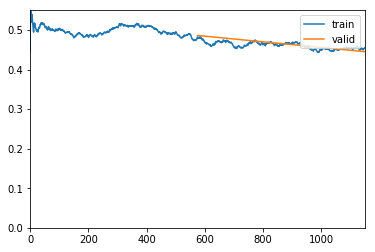

Better model found at epoch 0 with val_loss value: 0.4860960841178894.
Better model found at epoch 1 with val_loss value: 0.445086807012558.


In [28]:
learn.fit_one_cycle(2,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [35]:
learn.save('densenet169-stage-1')

In [36]:
learn = None
gc.collect()
torch.cuda.empty_cache()

In [37]:
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy], wd=0.1).to_fp16()
learn.load('densenet169-stage-1');

/home/nbuser/.anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


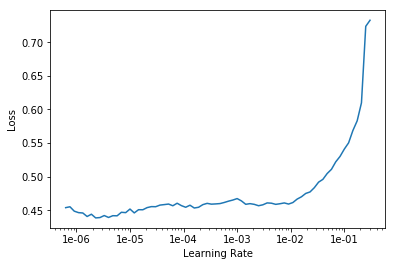

In [39]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.455981,0.447157,0.197373,0.802627,11:32
1,0.439138,0.443246,0.191429,0.808571,11:32
2,0.438542,0.433106,0.190491,0.809509,11:32
3,0.433307,0.435047,0.189865,0.810135,11:32
4,0.417274,0.433631,0.189553,0.810447,11:32


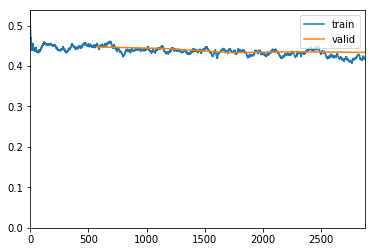

Better model found at epoch 0 with val_loss value: 0.44715654850006104.
Better model found at epoch 1 with val_loss value: 0.4432463049888611.
Better model found at epoch 2 with val_loss value: 0.4331061542034149.


In [40]:
lr = 1e-4
learn.fit_one_cycle(5,max_lr=lr,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [41]:
learn.save('densenet169-stage-2')

In [42]:
learn.load('densenet169-stage-2');

In [43]:
learn.purge()
learn.unfreeze()

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


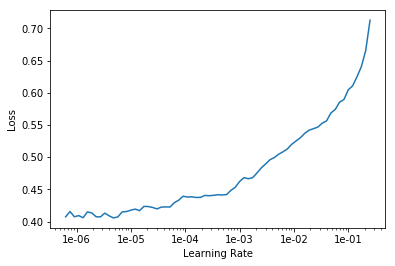

In [45]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.432884,0.433163,0.189553,0.810447,15:35
1,0.430365,0.432646,0.188302,0.811698,15:36
2,0.416295,0.435836,0.189240,0.810760,15:36
3,0.421190,0.434219,0.189553,0.810447,15:35
4,0.409845,0.432681,0.187050,0.812950,15:35


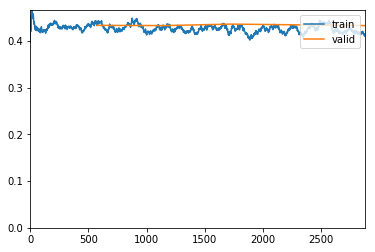

Better model found at epoch 0 with val_loss value: 0.43316349387168884.
Better model found at epoch 1 with val_loss value: 0.4326455295085907.


In [46]:
lr=3e-5
learn.fit_one_cycle(5,max_lr=slice(lr/100,lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [47]:
learn.save('densenet169-stage-3')

In [48]:
learn.load('densenet169-stage-3');

In [57]:
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy, kappa], wd=0.1).to_fp16()
learn.load('densenet169-stage-3');

/home/nbuser/.anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


epoch,train_loss,valid_loss,error_rate,accuracy,kappa_score,time
0,0.436955,0.433421,0.187363,0.812637,0.621217,11:32


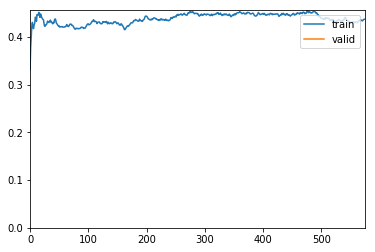

Better model found at epoch 0 with val_loss value: 0.4334206283092499.


In [58]:
learn.fit_one_cycle(1,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [59]:
learn.save('densenet169-stage-4')

In [77]:
size = 224
bs = 64

np.random.seed(42)
data = ImageDataBunch.from_folder(path/'data2', ds_tfms=get_transforms(flip_vert=True, max_warp=0.), 
                                  size=size, bs=bs,
                                  ).normalize(imagenet_stats)

In [78]:
learn = cnn_learner(data, models.densenet169, metrics=[error_rate, accuracy], wd=0.1)

/home/nbuser/.anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [79]:
learn.load('densenet169-stage-3');

In [80]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

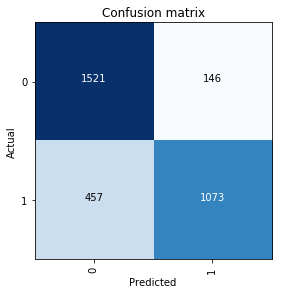

In [81]:
# first interpretation
interp.plot_confusion_matrix()

In [82]:
interp.most_confused(min_val=2)

[('1', '0', 457), ('0', '1', 146)]

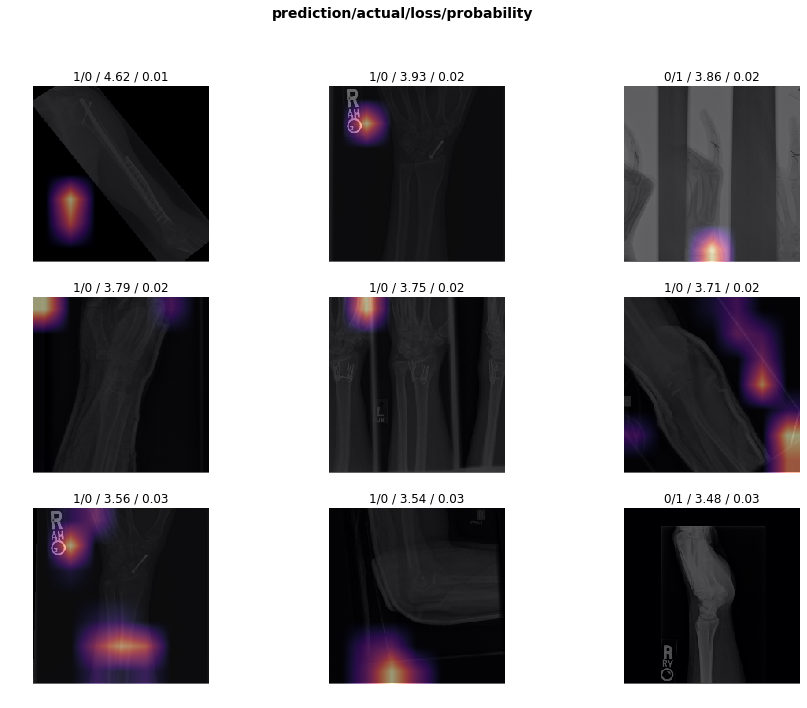

In [83]:
interp.plot_top_losses(9, figsize=(15,11))

## Heatmap

In [183]:
m = learn.model.eval()

Category 0

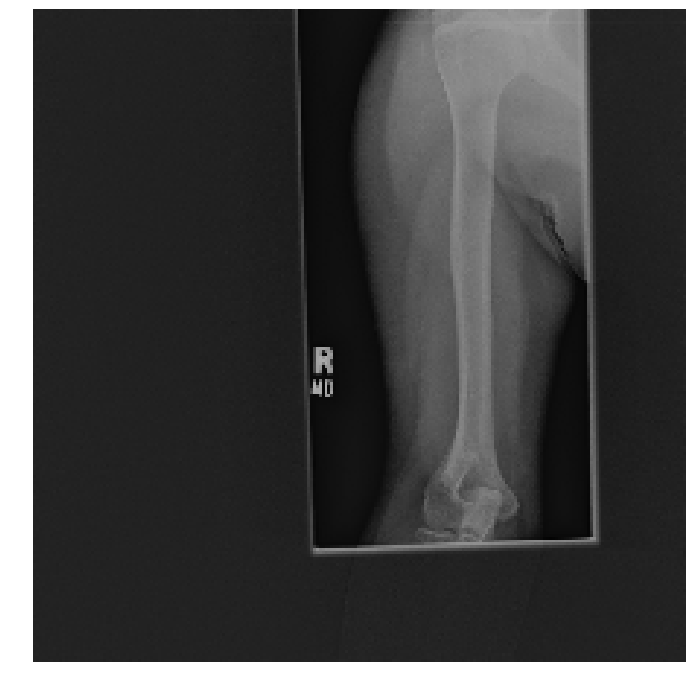

In [184]:
idx=0
x,y = data.valid_ds[idx]
x.show(figsize =(12,12))
data.valid_ds.y[idx]

In [185]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [186]:
from fastai.callbacks.hooks import *

In [187]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [188]:
hook_a,hook_g = hooked_backward()

In [189]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([1664, 7, 7])

In [190]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [191]:
def show_heatmap(hm):
    
    _,ax = plt.subplots(figsize =(12,12))
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma')

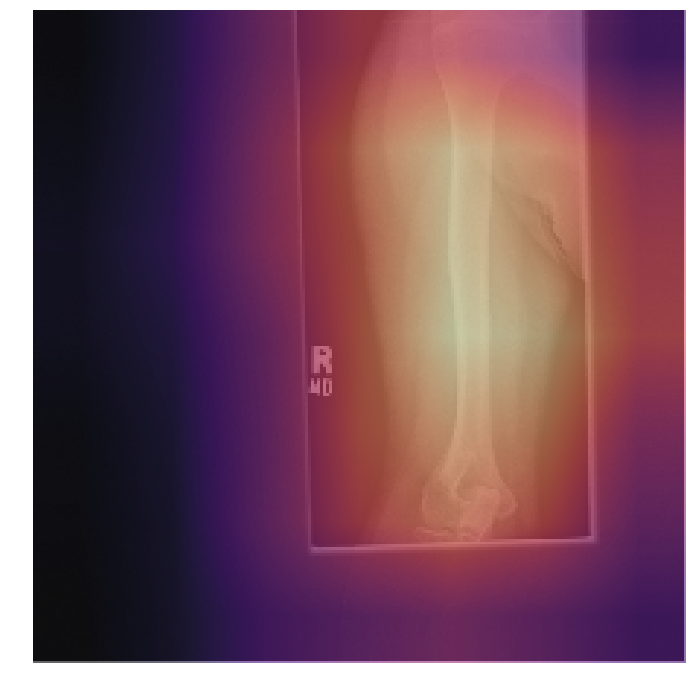

In [192]:
show_heatmap(avg_acts)

# Grad Cam

In [193]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([1664, 7, 7]), torch.Size([1664]))

In [194]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [195]:
fn = path/'valid/XR_FINGER/patient11191/study1_negative/image1.png' #Replace with your own image


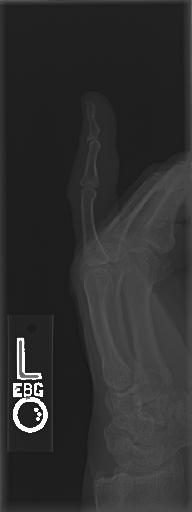

In [196]:
x = open_image(fn); x

In [197]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [198]:
hook_a,hook_g = hooked_backward()

In [199]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

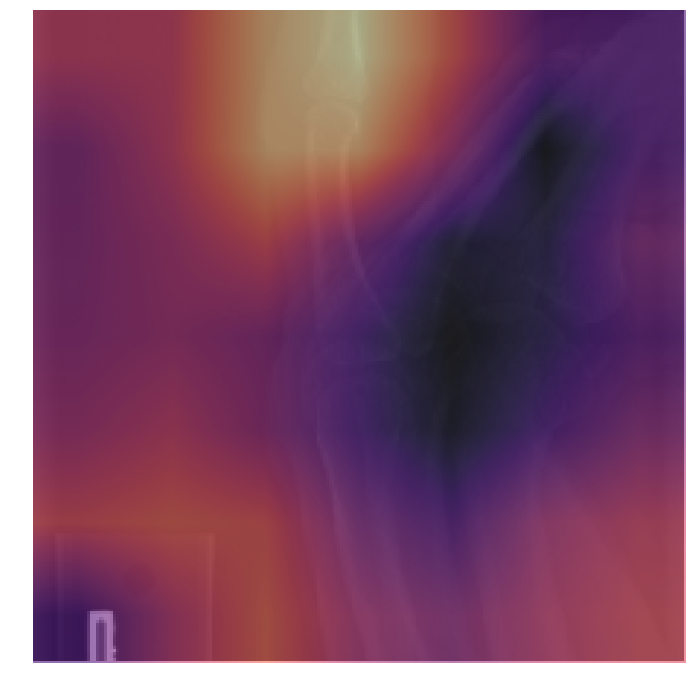

In [200]:
show_heatmap(mult)

In [149]:
data.classes[0]

'0'

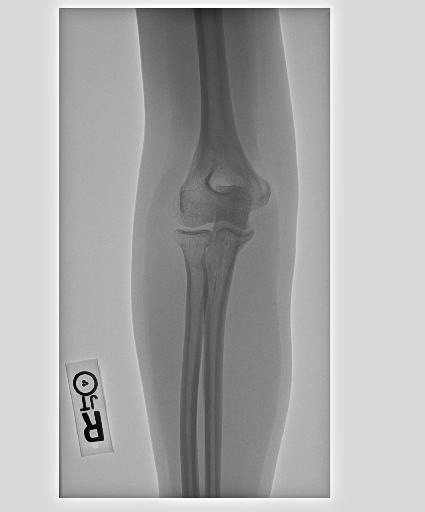

In [201]:
fn = path/'valid/XR_ELBOW/patient11205/study1_negative/image1.png' #Replace with your own image
x = open_image(fn); x

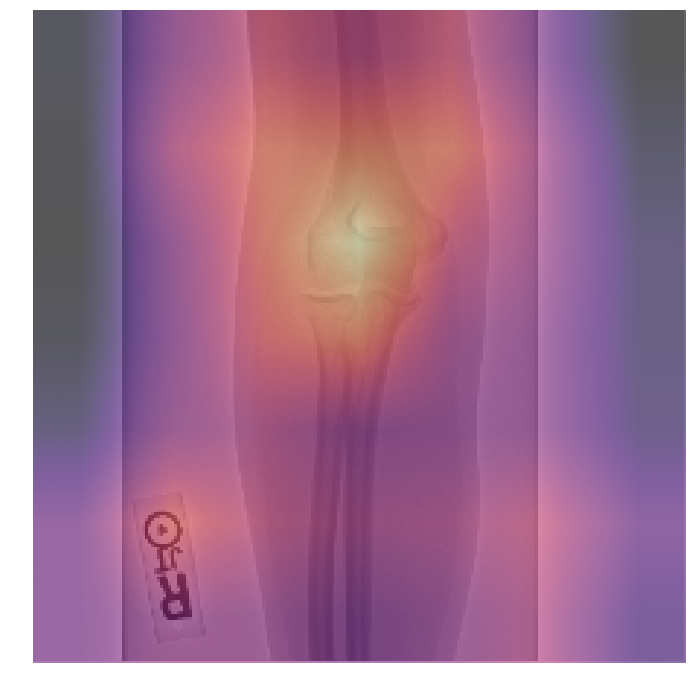

In [202]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
hook_a,hook_g = hooked_backward()
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)
show_heatmap(mult)

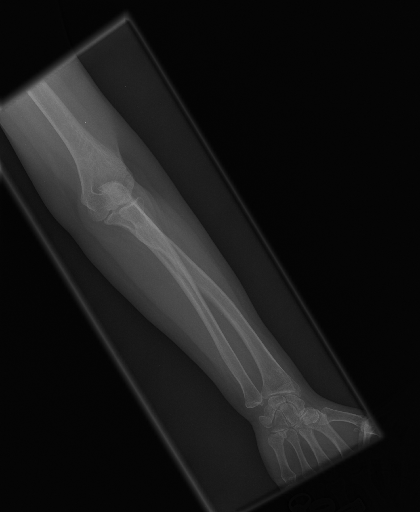

In [203]:
fn = path/'valid/XR_FOREARM/patient11191/study1_negative/image1.png' #Replace with your own image
x = open_image(fn); x

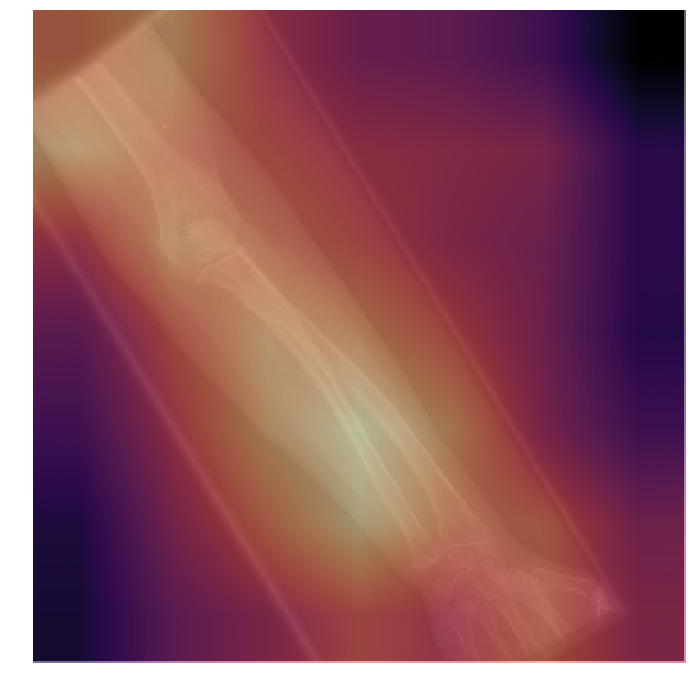

In [204]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
hook_a,hook_g = hooked_backward()
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)
show_heatmap(mult)

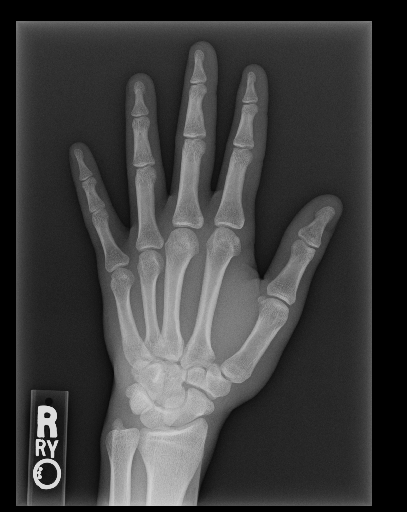

In [205]:
fn = path/'valid/XR_HAND/patient11192/study1_negative/image1.png' #Replace with your own image
x = open_image(fn); x

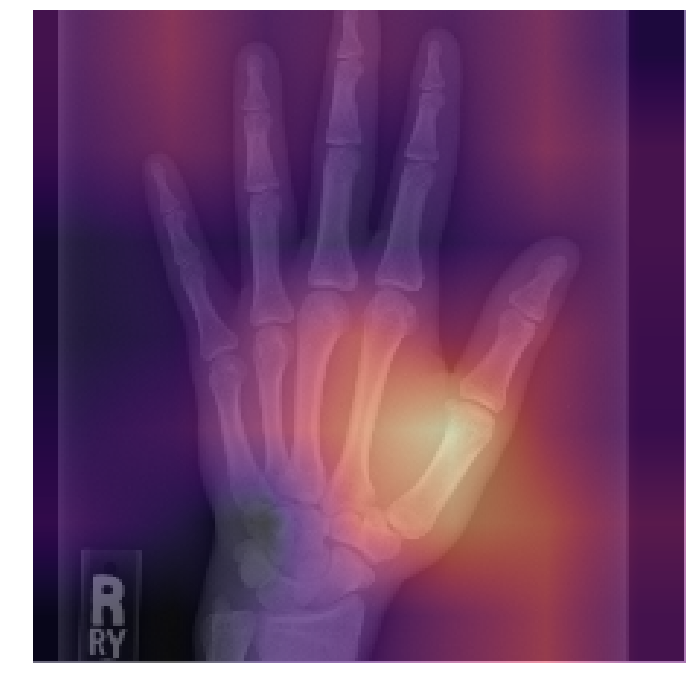

In [206]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
hook_a,hook_g = hooked_backward()
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)
show_heatmap(mult)

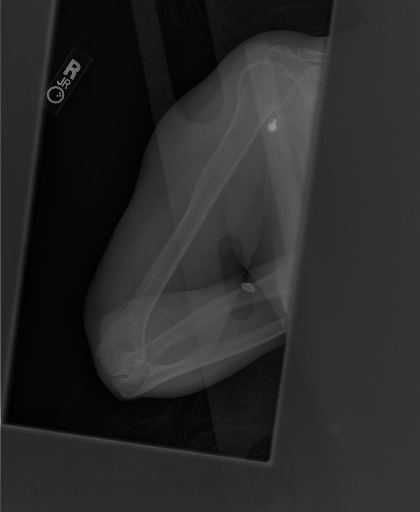

In [207]:
fn = path/'valid/XR_HUMERUS/patient11200/study1_negative/image1.png' #Replace with your own image
x = open_image(fn); x

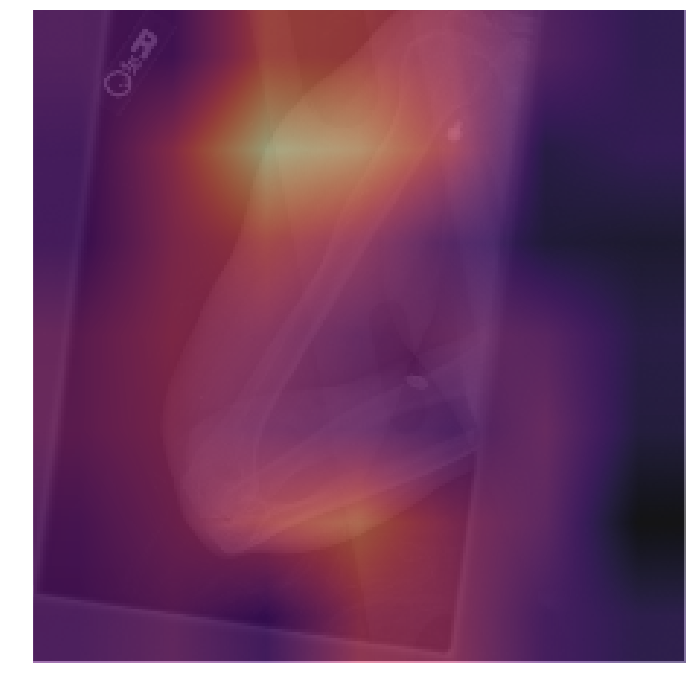

In [208]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
hook_a,hook_g = hooked_backward()
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)
show_heatmap(mult)

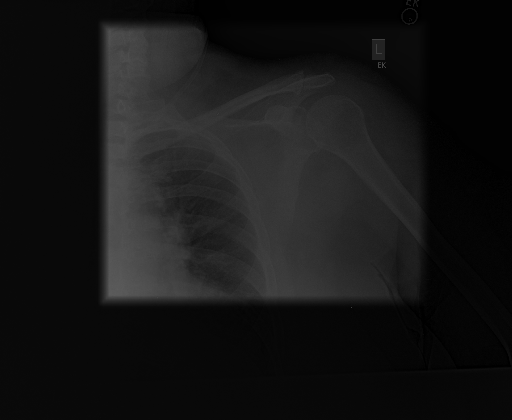

In [215]:
fn = path/'valid/XR_SHOULDER/patient11187/study1_negative/image3.png' #Replace with your own image
x = open_image(fn); x

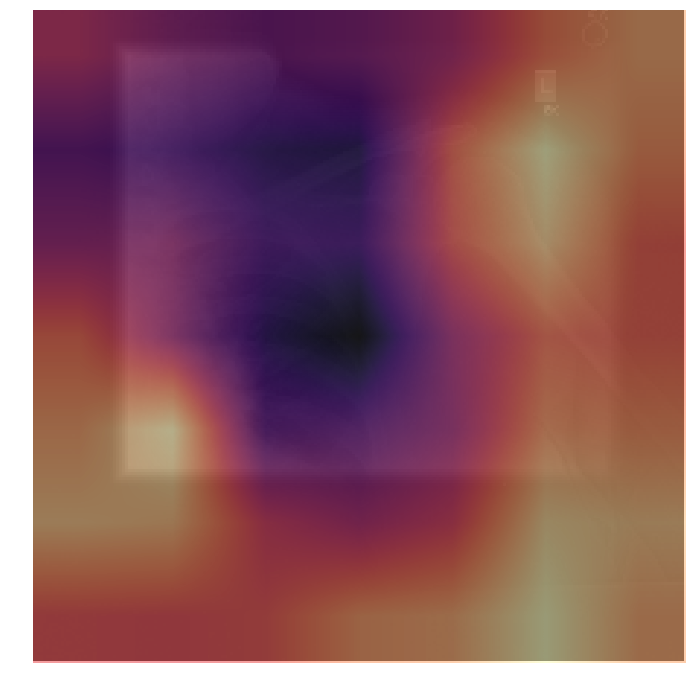

In [216]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
hook_a,hook_g = hooked_backward()
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)
show_heatmap(mult)

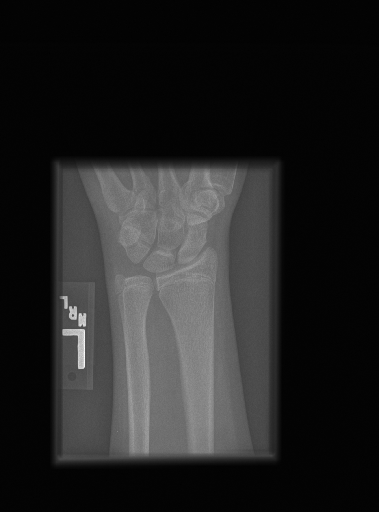

In [213]:
fn = path/'valid/XR_WRIST/patient11278/study2_negative/image2.png' #Replace with your own image
x = open_image(fn); x

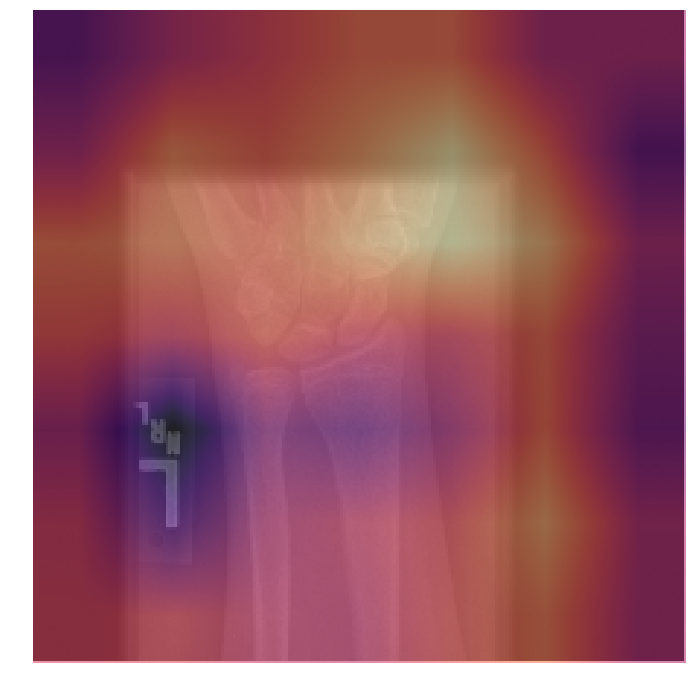

In [214]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
hook_a,hook_g = hooked_backward()
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)
show_heatmap(mult)

In [153]:
learn.load('densenet169-stage-3');

In [154]:
# validation
preds_val, y_val = learn.get_preds()

In [155]:
preds_val

tensor([[0.5072, 0.4928],
        [0.8898, 0.1102],
        [0.1046, 0.8954],
        ...,
        [0.6830, 0.3170],
        [0.0418, 0.9582],
        [0.0170, 0.9830]])

In [156]:
len(preds_val)

3197

In [157]:
for img_url in data.valid_ds.x.items:
    print(img_url)
    break

data2/valid/0/HUMERUS_patient11691_study1_negative_image1.png


In [158]:
pat_label = re.compile(r'/([^/]+)_patient[^/]+.png$')
pat_study = re.compile(r'/([^/]+)_[^_]+.png$')

In [159]:
%%time
studies = dict()
studies_num = dict()
labels_num = dict()
labels =dict()
for m in mura:
    labels_num[m] = 0

for idx, src in enumerate(data.valid_ds.x.items):
    # get label name
    label = pat_label.search(str(src))
    label = label.group(1) 
    # get study name
    study = pat_study.search(str(src))
    study = study.group(1) 
    # sum probabilities by study
    if study in studies:
        studies[study] += preds_val[idx,:].clone()
        studies_num[study] += 1
    else:
        studies[study] = preds_val[idx,:].clone()
        studies_num[study] = 1
    labels[study] = label

CPU times: user 88 ms, sys: 8 ms, total: 96 ms
Wall time: 92.3 ms


In [160]:
labels_num = dict()
for m in mura:
    labels_num[m] = sum([1 for k,v in labels.items() if v.lower() == m])

In [161]:
print(labels_num)
print(sum([v for k,v in labels_num.items()]))

{'elbow': 158, 'finger': 175, 'forearm': 133, 'hand': 167, 'humerus': 135, 'shoulder': 194, 'wrist': 237}
1199


In [162]:
len(studies)

1199

In [163]:
len(studies_num)

1199

In [164]:
# get averages
for (k,v) in studies.items():
    studies[k] = studies[k] / studies_num[k]

In [165]:
# get predictions by study
acc = 0.
for (k,v) in studies.items():
    prob, y_hat = torch.max(studies[k],0)
    if 'negative' in k:
        acc += (0 == y_hat.item())
    else:
        acc += (1 == y_hat.item())
    # print(f'{k} {y_hat.item()} ({prob})')

In [166]:
len(studies), acc

(1199, 984.0)

In [167]:
# get study accuracy total
print(f'study accuracy total: {round(acc / len(studies),3)}')

study accuracy total: 0.821


In [168]:
# get predictions by study and label
acc_label = dict()
for m in mura:
    acc_label[m] = 0
    
for (k,v) in studies.items():
    prob, y_hat = torch.max(studies[k],0)
    label = labels[k]
    if 'negative' in k:
        acc_label[label.lower()] += (0 == y_hat.item())
    else:
        acc_label[label.lower()] += (1 == y_hat.item())

In [169]:
acc_label

{'elbow': 134,
 'finger': 136,
 'forearm': 113,
 'hand': 128,
 'humerus': 117,
 'shoulder': 152,
 'wrist': 204}

In [170]:
sum([v for k,v in acc_label.items()])

984

In [171]:
labels_num

{'elbow': 158,
 'finger': 175,
 'forearm': 133,
 'hand': 167,
 'humerus': 135,
 'shoulder': 194,
 'wrist': 237}

In [172]:
# get study accuracy by label
for m in mura:
    print(f'{m}: {round(acc_label[m] / labels_num[m],3)}')

elbow: 0.848
finger: 0.777
forearm: 0.85
hand: 0.766
humerus: 0.867
shoulder: 0.784
wrist: 0.861
